# Udacity - CarND - Advanced Lane Finding

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

# 1.0 Modules to import

In [70]:
import numpy as np
import os
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob

# To process video clip
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# 2.0 Configuration

In [71]:
config = {
    'camera_calibration_folder' : './camera_cal',
    'test_images_folder' : './test_images'
}

# 3. Camera Calibration

## 3.1 Calibration class 

In [72]:
class Calibrator:
    def __init__(self):
        self.calibration_images = []
        self.objpoints = [] # 3D points in real-world space
        self.imgpoints = [] # 2D points in image space
               
        self.camera_matrix = None
        self.distortion_coefficients = None
        self.rotation_vectors = None
        self.translation_vectors = None
        
        self.calibrated = False
        
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
        # assuming that the chessboards have shape 9x6
        # Note that the z-coordiate is zero for all points
        self.objp = np.zeros((6*9,3), np.float32)
        self.objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
        
        self.load_calibration_images()
        self.collect_corners()      
    
    def load_calibration_images(self):
        calibration_filenames = glob.glob(config['camera_calibration_folder']+'/*.jpg')
        for fname in calibration_filenames:
            img = mpimg.imread(fname)
            self.calibration_images.append(img)
        
        # Save the shape of the calibration images
        self.image_shape = self.calibration_images[0].shape[1::-1]
            
    def collect_corners(self):
        # Iterate through images for their points
        for image in self.calibration_images:
            # Comvert image to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # Find chessborad corners
            ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
            if ret == True:
                self.objpoints.append(self.objp)
                self.imgpoints.append(corners)
                            
    def calibrate(self):
        self.calibrated, self.camera_matrix, self.distortion_coefficients, self.rotation_vectors, self.translation_vectors = cv2.calibrateCamera(
            self.objpoints, self.imgpoints, self.image_shape, None, None)
                    
    def undistorted(self, img):
        undist = cv2.undistort(img, self.camera_matrix, 
                               self.distortion_coefficients, None, 
                               self.camera_matrix)
        return undist
    
    def show(self, img):
        # img is in BGR
        # Plotting calibration
        undistorted_img = self.undistorted(img)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('Original image')
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        ax2.set_title('Undistorted image')
        ax2.imshow(cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB))

## 3.2. Calibrate 

In [73]:
cal = Calibrator()
cal.calibrate()

## 3.3. Examples: Calibration 

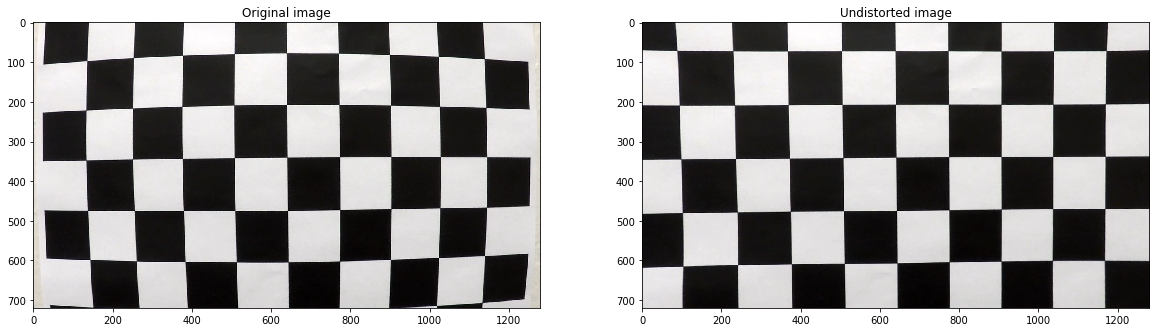

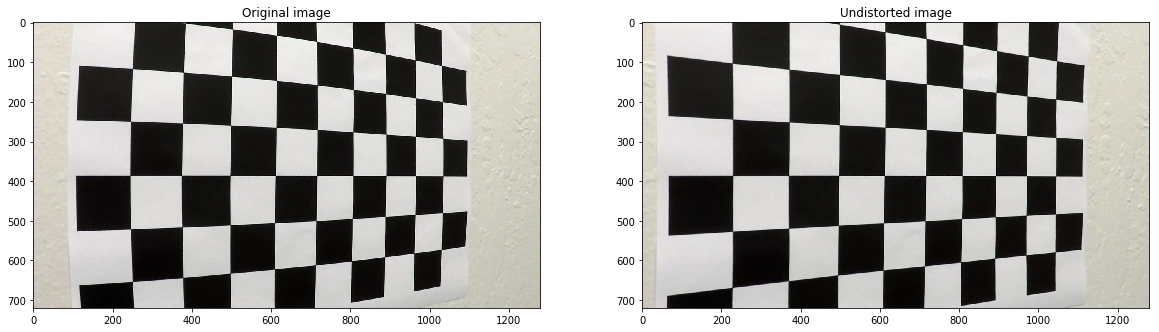

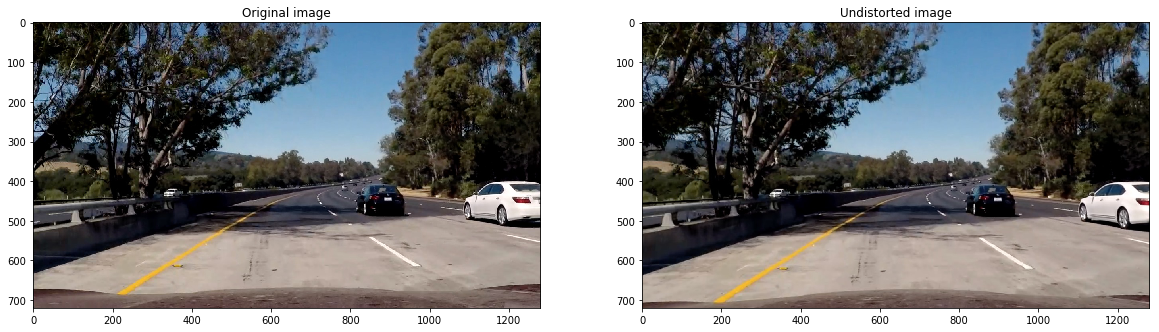

In [74]:
img = cv2.imread(config['camera_calibration_folder'] + '/calibration1.jpg')
cal.show(img)

img = cv2.imread(config['camera_calibration_folder'] + '/calibration5.jpg')
cal.show(img)

img = cv2.imread(config['test_images_folder'] + '/test5.jpg')
cal.show(img)

# 4. Exploring thresholds

In [96]:
class Thresholds:
    def __init__(self):
        pass
    
    def H_binary(self, img, th=(120, 255)):
        # Convert from BGR to HLS colorspace
        HLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        H = HLS[:,:,0]
        
        binary = np.zeros_like(H)
        binary[(H >= th[0]) & (H <= th[1])] = 1
        return binary
    
    def L_binary(self, img, th=(120, 255)):
        # Convert from BGR to HLS colorspace
        HLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        L = HLS[:,:,1]
        
        binary = np.zeros_like(L)
        binary[(L >= th[0]) & (L <= th[1])] = 1
        return binary
    
    def S_binary(self, img, th=(100, 255)):
        # Convert from BGR to HLS colorspace
        HLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        S = HLS[:,:,2]
        
        binary = np.zeros_like(S)
        binary[(S >= th[0]) & (S <= th[1])] = 1
        return binary

    def R_binary(self, img, th=(180, 255)):
        # Note that img is in BGR
        R = img[:,:,2]
        
        binary = np.zeros_like(R)
        binary[(R >= th[0]) & (R <= th[1])] = 1
        return binary
    
    def B_binary(self, img, th=(100, 255)):
        # Note that img is in BGR
        B = img[:,:,0]
        
        binary = np.zeros_like(B)
        binary[(B >= th[0]) & (B <= th[1])] = 1
        return binary
    
    def G_binary(self, img, th=(100, 155)):
        # Note that img is in BGR
        G = img[:,:,1]
        
        binary = np.zeros_like(G)
        binary[(G >= th[0]) & (G <= th[1])] = 1
        return binary
        
    def LAB_B_binary(self, img, th=(155, 200)):
        # Convert from BGR to HLS colorspace
        LAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        B = LAB[:,:,2]
        
        binary = np.zeros_like(B)
        binary[(B >= th[0]) & (B <= th[1])] = 1
        return binary
    
    def LUV_L_binary(self, img, th=(225, 255)):
        # Convert from BGR to HLS colorspace
        LUV = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        L = LUV[:,:,0]
        
        binary = np.zeros_like(L)
        binary[(L >= th[0]) & (L <= th[1])] = 1
        return binary
    
    def sobel_absolute(self, img, th=(10, 100)):
        # Convert from BGR to HLS colorspace
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        binary = np.zeros_like(scaled_sobelx)
        binary[(scaled_sobelx >= th[0]) & (scaled_sobelx <= th[1])] = 1
        
        return binary
    
    def sobel_magnitude(self, img, th=(25, 255)):   
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Take the gradient in x and y separately
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        # Calculate the magnitude 
        mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
        # Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
        # Create a binary mask where mag thresholds are met
        binary = np.zeros_like(scaled_sobel)
        binary[(scaled_sobel >= th[0]) & (scaled_sobel <= th[1])] = 1
        
        return binary
    
    def sobel_direction(self, img, th=(0, 0.09)):    
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Take the gradient in x and y separately
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=7)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=7)
        # Take the absolute value of the x and y gradients
        abs_sobelx = np.absolute(sobelx)
        abs_sobely = np.absolute(sobely)
        # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
        grad_dir = np.arctan2(abs_sobely, abs_sobelx)
        # Create a binary mask where direction thresholds are met
        binary =  np.zeros_like(grad_dir)
        binary[(grad_dir >= th[0]) & (grad_dir <= th[1])] = 1
        # Return this mask as your binary_output image
        return binary
    
th_obj = Thresholds()

## 4.1. RGB thresholds

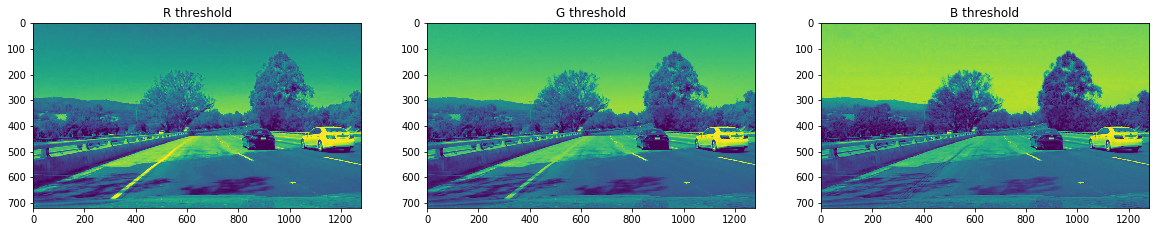

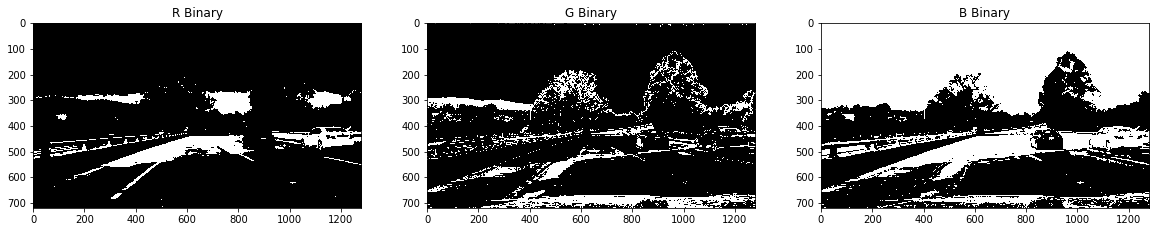

In [97]:
img = cv2.imread(config['test_images_folder']+'/test4.jpg')
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
ax1.set_title('R threshold')
ax1.imshow(image[:,:,0])

ax2.set_title('G threshold')
ax2.imshow(image[:,:,1])

ax3.set_title('B threshold')
ax3.imshow(image[:,:,2])

f, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(20,5))

ax4.set_title('R Binary')
ax4.imshow(th_obj.R_binary(img), cmap='gray')


ax5.set_title('G Binary')
ax5.imshow(th_obj.G_binary(img), cmap='gray')


ax6.set_title('B Binary')
ax6.imshow(th_obj.B_binary(img), cmap='gray')


## 4.2. HLS thresholds

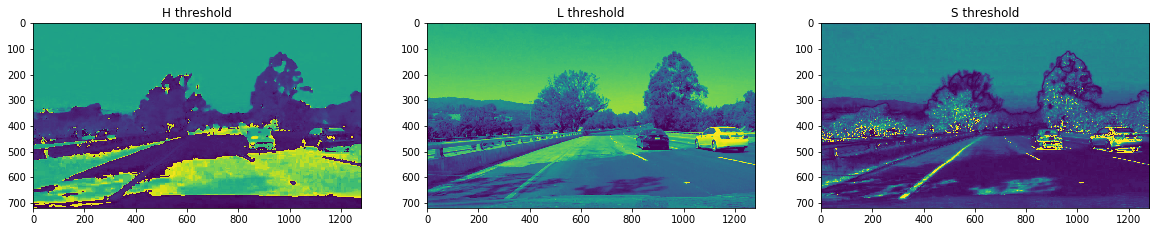

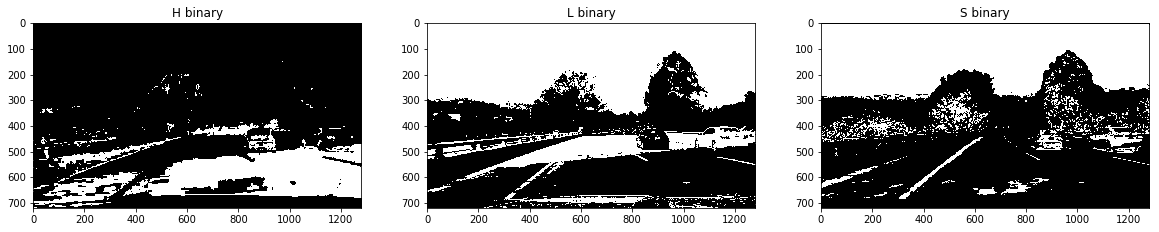

In [98]:
img = cv2.imread(config['test_images_folder']+'/test4.jpg')
image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('H threshold')
ax1.imshow(image[:,:,0])

ax2.set_title('L threshold')
ax2.imshow(image[:,:,1])

ax3.set_title('S threshold')
ax3.imshow(image[:,:,2])

f, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(20,10))

ax4.set_title('H binary')
ax4.imshow(th_obj.H_binary(img), cmap='gray')

ax5.set_title('L binary')
ax5.imshow(th_obj.L_binary(img), cmap='gray')

ax6.set_title('S binary')
ax6.imshow(th_obj.S_binary(img), cmap='gray')

## 4.3. LUV L threshold

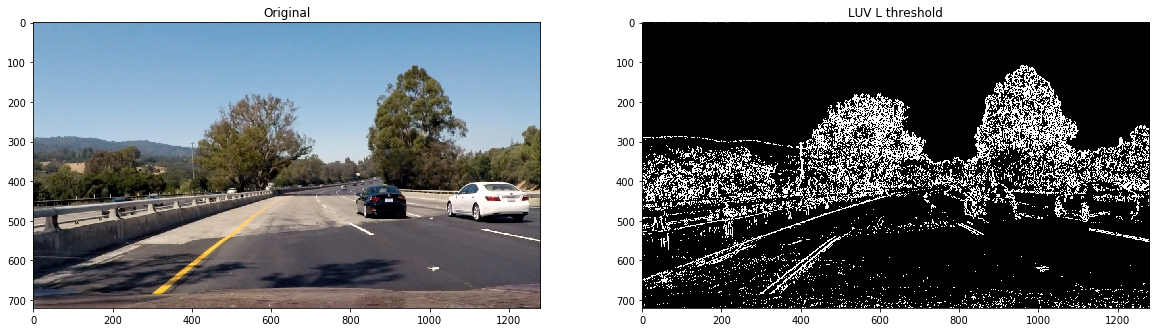

In [102]:
img = cv2.imread(config['test_images_folder']+'/test4.jpg')
LUV_L_binary = th_obj.LUV_L_binary(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original')
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

ax2.set_title('LUV L threshold')
ax2.imshow(sobel_absolute_binary, cmap='gray')

## 4.4. LAB B threshold

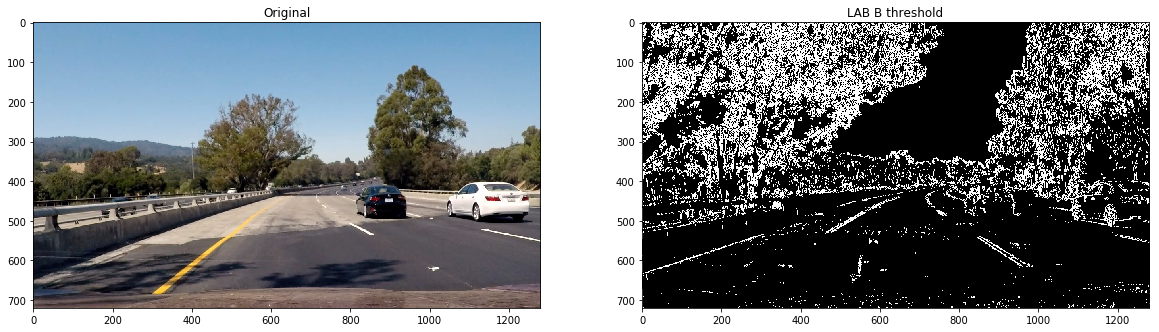

In [105]:
img = cv2.imread(config['test_images_folder']+'/test4.jpg')
LAB_B_binary = th_obj.LAB_B_binary(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original')
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

ax2.set_title('LAB B threshold')
ax2.imshow(sobel_absolute_binary, cmap='gray')

## 4.5. Sobel Absolute thresholds

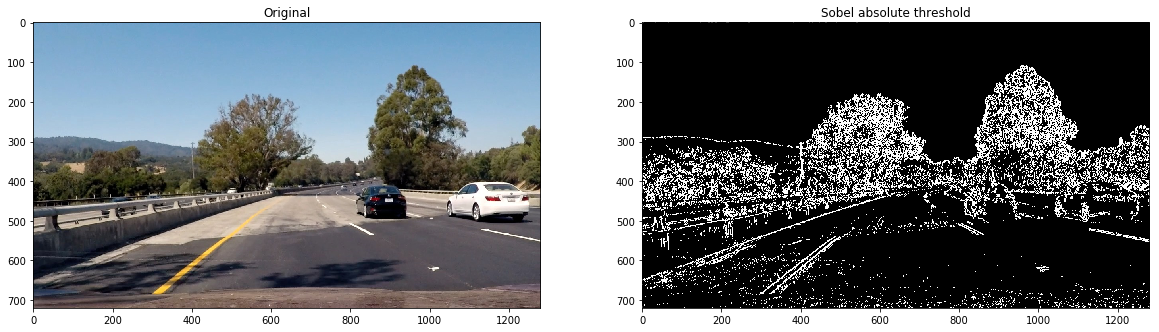

In [106]:
img = cv2.imread(config['test_images_folder']+'/test4.jpg')
sobel_absolute_binary = th_obj.sobel_absolute(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original')
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

ax2.set_title('Sobel absolute threshold')
ax2.imshow(sobel_absolute_binary, cmap='gray')

## 4.6. Sobel Magnitude thresholds

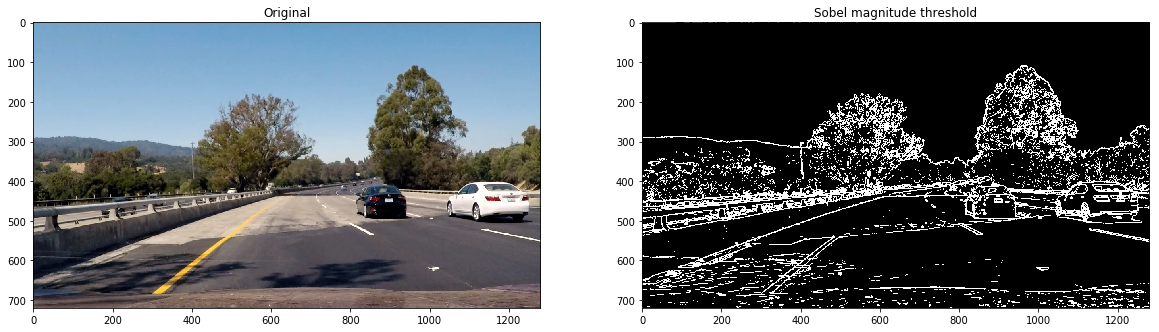

In [79]:
img = cv2.imread(config['test_images_folder']+'/test4.jpg')
sobel_magnitude_binary = th_obj.sobel_magnitude(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original')
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

ax2.set_title('Sobel magnitude threshold')
ax2.imshow(sobel_magnitude_binary, cmap='gray')

## 4.7. Sobel Direction thresholds

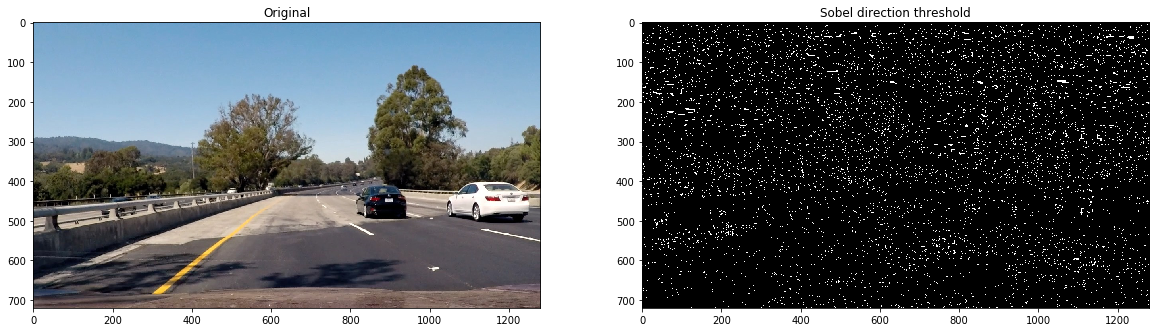

In [80]:
img = cv2.imread(config['test_images_folder']+'/test4.jpg')
sobel_direction_binary = th_obj.sobel_direction(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original')
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

ax2.set_title('Sobel direction threshold')
ax2.imshow(sobel_direction_binary, cmap='gray')

## 4.8. Threshold summary 

* Since R in the RGB gives the clearest lane lines, I use RGB R with threshold (200, 255)
* Since S in the HLS gives the clearest lane lines, I use HLS S with threshold (120, 255)
* Since Sobel absolute (very similar to LUV L) gives clearer lane lines on the dark surface, I use this with threshold (10, 100)
* Since LAB B detects the white lines clearer, I use LAB B with threshold (155-200) 

# 5. Pipeline

In [107]:
#################################################################################################################
class Pipeline:
    def __init__(self):
        self.th = Thresholds()
        self.left_line = self.LineFits()
        self.right_line = self.LineFits()
        self.result = None
        pass
        
    def binary_image(self, img, S_th=(120,255), R_th=(200,255), sobelx_th=(10,100)):
    # Create binary image combining S channel and the L-channel-gradient thresholds 
        undistorted_img = cal.undistorted(img)
        
        S_binary = th_obj.S_binary(undistorted_img, th=S_th)
        R_binary = th_obj.R_binary(undistorted_img, th=R_th)
        LAB_B_binary = th_obj.LAB_B_binary(undistorted_img)
        sobelx_binary = th_obj.sobel_absolute(undistorted_img, th=sobelx_th)
        
        color_binary = np.dstack(( np.zeros_like(sobelx_binary), sobelx_binary, S_binary, R_binary)) * 255   
        
        # Combine the three binary thresholds
        combined_binary = np.zeros_like(sobelx_binary)
        
        combined_binary[((S_binary == 1) & (R_binary == 1)) |
                        ((S_binary == 1) & (LAB_B_binary == 1)) |
                        ((S_binary == 1) & (sobelx_binary == 1)) |
                        ((R_binary == 1) & (LAB_B_binary == 1)) |
                        ((R_binary == 1) & (sobelx_binary == 1)) |
                        ((LAB_B_binary == 1) & (sobelx_binary == 1))] = 1
        return color_binary, combined_binary
    
    def get_binary_image(self, img, S_th=(120,255), R_th=(200,255), sobelx_th=(10,100)):
        color_binary, combined_binary = self.binary_image(img, S_th, R_th, sobelx_th)
        return combined_binary
    
    def perspective_transformed(self, img):
        # Put the image through the pipeline to get the binary image
        binary_img = self.get_binary_image(img)

        # Undistort
        undistorted_img = cal.undistorted(binary_img)
        #undist = cv2.undistort(binary_img, mtx, dist, None, mtx)

        # Grab the image shape
        img_size = (undistorted_img.shape[1], undistorted_img.shape[0])

        # Source points - defined area of lane line edges
        src = np.float32([[690,450],[1110,img_size[1]],[175,img_size[1]],[595,450]])

        # 4 destination points to transfer
        offset = 300 # offset for dst points
        
        dst = np.float32([[img_size[0]-offset, 0],[img_size[0]-offset, img_size[1]],
                          [offset, img_size[1]],[offset, 0]])
        
        # Use cv2.getPerspectiveTransform() to get M, the transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        
        Minv = cv2.getPerspectiveTransform(dst, src)

        # Use cv2.warpPerspective() to warp the image to a top-down view
        top_down = cv2.warpPerspective(undistorted_img, M, img_size)

        return top_down, M, Minv
    
  
    def histogram_of_perspective_transformed_binary_image(self, img):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
        return histogram

    # Define method to fit polynomial to binary image with lines extracted, using sliding window
    def sliding_window_polyfit(self, img):
        histogram = self.histogram_of_perspective_transformed_binary_image(img)
        
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((img, img, img))*255
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//1.75)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        # Choose the number of sliding windows
        nwindows = 10
        # Set height of windows
        window_height = np.int(img.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 80
        # Set minimum number of pixels found to recenter window
        minpix = 40
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []


        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = img.shape[0] - (window+1)*window_height
            win_y_high = img.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & 
                              (nonzeroy < win_y_high) & 
                              (nonzerox >= win_xleft_low) &  
                              (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & 
                               (nonzeroy < win_y_high) & 
                               (nonzerox >= win_xright_low) &  
                               (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        (left_fit, right_fit) = (None, None)
        if len(leftx)!=0:
            left_fit = np.polyfit(lefty, leftx, 2)
        if len(rightx)!=0:
            right_fit = np.polyfit(righty, rightx, 2) 

        result = {
            'left_fit' : left_fit,
            'right_fit' : right_fit,
            'left_lane_inds' : left_lane_inds,
            'right_lane_inds' : right_lane_inds,
            'out_img' : out_img,
            'nonzero' : nonzero,
            'nonzerox' : nonzerox,
            'nonzeroy' : nonzeroy,
            'margin' : margin
        }
        return result
       
    def sliding_window_polyfit_show(self, img, result, ax):
        # Generate x and y values for plotting
        left_fit = result['left_fit']
        right_fit = result['right_fit']
        left_lane_inds = result['left_lane_inds']
        right_lane_inds = result['right_lane_inds']
        out_img = result['out_img']
        nonzero = result['nonzero']
        nonzerox = result['nonzerox']
        nonzeroy = result['nonzeroy']
        
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        ax.imshow(out_img)
        ax.plot(left_fitx, ploty, color='yellow')
        ax.plot(right_fitx, ploty, color='yellow')
        
    def polyfit_using_prev_fit(self, img, left_fit_prev, right_fit_prev):
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "img")
        # It's now much easier to find line pixels!
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 80
        
        left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + 
        left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + 
        left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + 
        right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + 
        right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        # Fit a second order polynomial to each
        (left_fit, right_fit) = (None, None)
        if len(leftx)!=0:
            left_fit = np.polyfit(lefty, leftx, 2)
        if len(rightx)!=0:
            right_fit = np.polyfit(righty, rightx, 2)
                
        result = {
            'left_lane_inds' : left_lane_inds,
            'right_lane_inds' : right_lane_inds,
            'left_fit' : left_fit,
            'right_fit' : right_fit,
            'nonzero' : nonzero,
            'nonzerox' : nonzerox,
            'nonzeroy' : nonzeroy,
            'margin' : margin
        }
        return result        
        
    def polyfit_using_prev_fit_show(self, img, result, ax):        
        left_lane_inds = result['left_lane_inds']
        right_lane_inds = result['right_lane_inds']
        left_fit = result['left_fit']
        right_fit = result['right_fit']
        nonzero = result['nonzero']
        nonzerox = result['nonzerox']
        nonzeroy = result['nonzeroy']
        margin = result['margin']
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((img, img, img))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        ax.imshow(result)
        ax.plot(left_fitx, ploty, color='yellow')
        ax.plot(right_fitx, ploty, color='yellow')
        
        
    def radius_of_curvature_and_center_distance(self, img, result):
        left_fit = result['left_fit']
        right_fit = result['right_fit']
        left_lane_inds = result['left_lane_inds']
        right_lane_inds = result['right_lane_inds']
            
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 
        xm_per_pix = 3.7/700 
        left_curverad, right_curverad, center_dist = (0, 0, 0)
        # Define y-value where we want radius of curvature
           
        h = img.shape[0]
        ploty = np.linspace(0, h-1, h)
        y_eval = np.max(ploty)

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
            
        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        if len(leftx) != 0 and len(rightx) != 0:
            # Fit new polynomials to x,y in world space
            left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
            right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
            
            # Calculate the new radii of curvature
            left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
            right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
            
        # Now our radius of curvature is in meters
        # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
        if right_fit is not None and left_fit is not None:
            car_position = img.shape[1]/2
            l_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
            r_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
            lane_center_position = (r_fit_x_int + l_fit_x_int) /2
            center_dist = (car_position - lane_center_position) * xm_per_pix
        return left_curverad, right_curverad, center_dist
    
    def draw_lane(self, original_img, binary_img, left_fit, right_fit, Minv):
        new_img = np.copy(original_img)
        if left_fit is None or right_fit is None:
            return original_img
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        h,w = binary_img.shape
        ploty = np.linspace(0, h-1, num=h) # to cover same y-range as image
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
        cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
        # Combine the result with the original image
        result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
        return result
    
    ###########################################################
    class LineFits:
        def __init__(self):
            self.detected = False  # was the line detected in the last iteration?
            self.best_fit = None   # polynomial coefficients averaged over the last n iterations
            self.current_fit = []  # polynomial coefficients for the most recent fit
            self.diffs = np.array([0,0,0], dtype='float') #difference in fit coefficients between last and new fits
           
        def add(self, fit, inds):
            # add a found fit to the line, up to n
            if fit is not None:
                if self.best_fit is not None:
                    # if we have a best fit, see how this new fit compares
                    self.diffs = abs(fit-self.best_fit)
                if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and len(self.current_fit) > 0:
                    self.detected = False
                else:
                    self.detected = True
                    self.current_fit.append(fit)
                    if len(self.current_fit) > 5: # throw out old fits, keep newest n                       
                        self.current_fit = self.current_fit[len(self.current_fit)-5:]
                    self.best_fit = np.average(self.current_fit, axis=0)
            else: # or remove one from the history, if not found
                self.detected = False
                if len(self.current_fit) > 0:
                    self.current_fit = self.current_fit[:len(self.current_fit)-1]
                if len(self.current_fit) > 0:
                    self.best_fit = np.average(self.current_fit, axis=0)
    ###########################################################
    
    def fit_value_quadratic(self, A, x):
        return (A[0] * x**2 + A[1] * x + A[2])
    
    def curvature_data(self, img, radius, center_distance):
        h = img.shape[0]
        font = cv2.FONT_HERSHEY_DUPLEX
        text = 'Radius of curvature: ' + '{:04.2f}'.format(radius) + 'm'
        cv2.putText(img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
        direction = ''
        if center_distance > 0:
            direction = 'right'
        elif center_distance < 0:
            direction = 'left'
        abs_center_distance = abs(center_distance)
        text = '{:04.3f}'.format(abs_center_distance) + 'm ' + direction + ' of center'
        cv2.putText(img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
        return img
    
    def process_image(self, img):
        warped_binary, M, Minv = self.perspective_transformed(img)
        
        if self.left_line.detected==False or self.right_line.detected==False:
            self.result = self.sliding_window_polyfit(warped_binary)
        else:
            self.result = self.polyfit_using_prev_fit(warped_binary, self.left_line.best_fit, self.right_line.best_fit)
            
        self.left_line.add(self.result['left_fit'], self.result['left_lane_inds'])
        self.right_line.add(self.result['right_fit'], self.result['right_lane_inds'])
        
        # draw the current best fit if it exists
        if self.left_line.best_fit is not None and self.right_line.best_fit is not None:
            final_t = self.draw_lane(img, warped_binary, self.left_line.best_fit, self.right_line.best_fit, Minv)
            left_radius, right_radius, center_distance = self.radius_of_curvature_and_center_distance(warped_binary, self.result)
            final = self.curvature_data(final_t, (left_radius+right_radius)/2, center_distance)
        else:
            final = img

        return final
#################################################################################################################

## 5.1. Examples: Thresholding, transformation of perspective, Histogram, Polyfitting

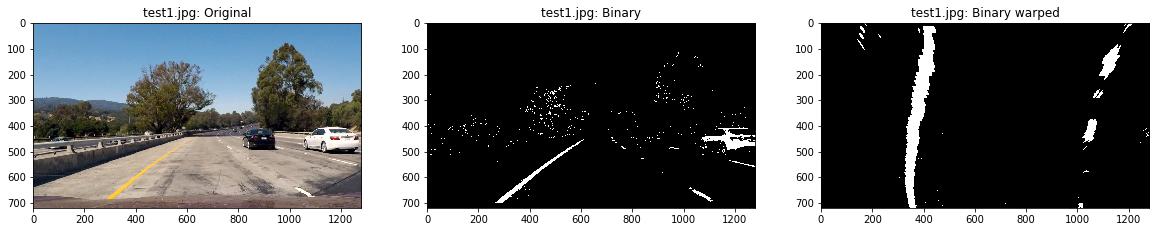

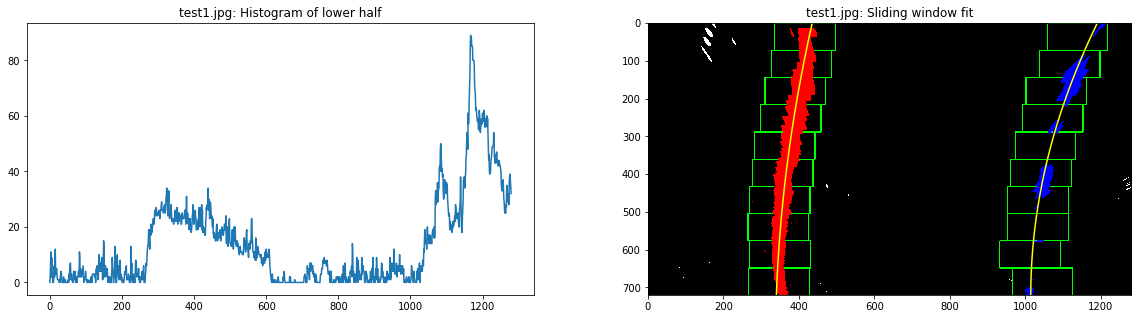

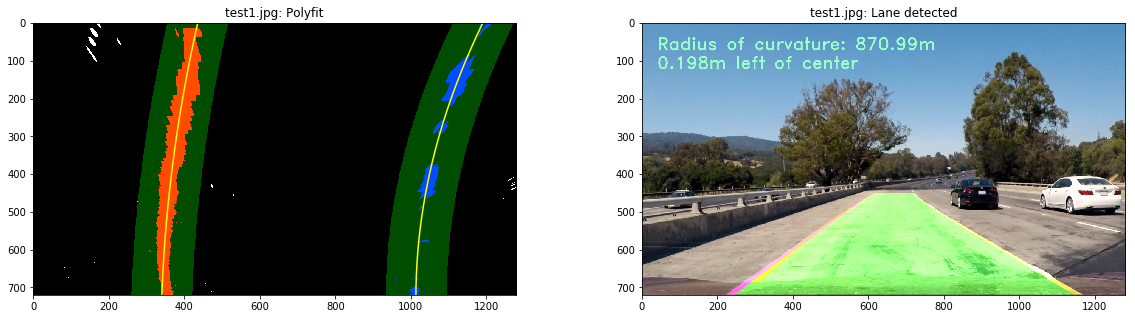

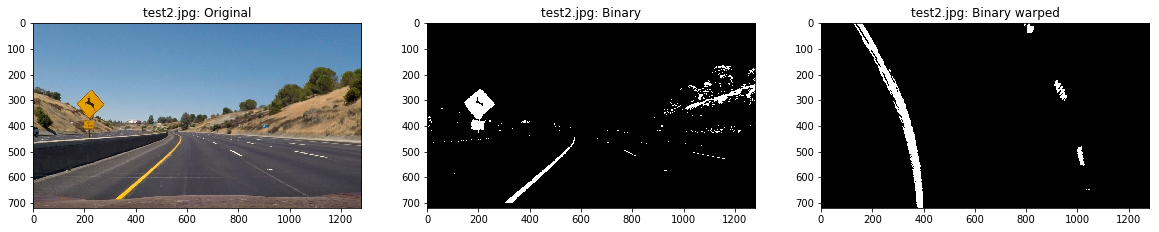

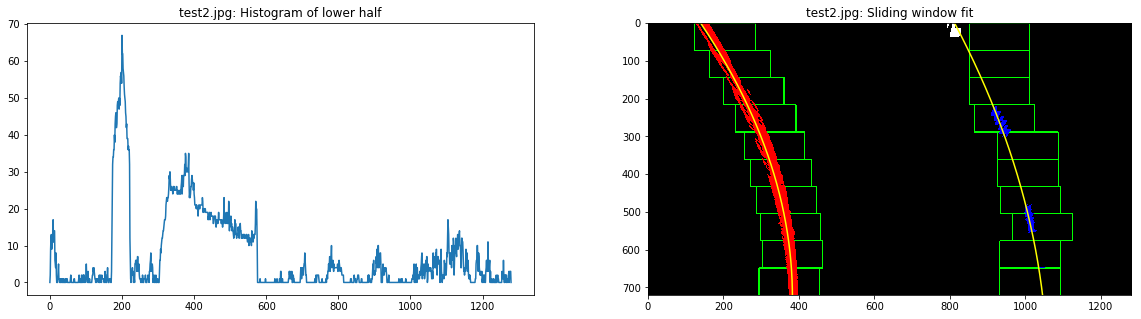

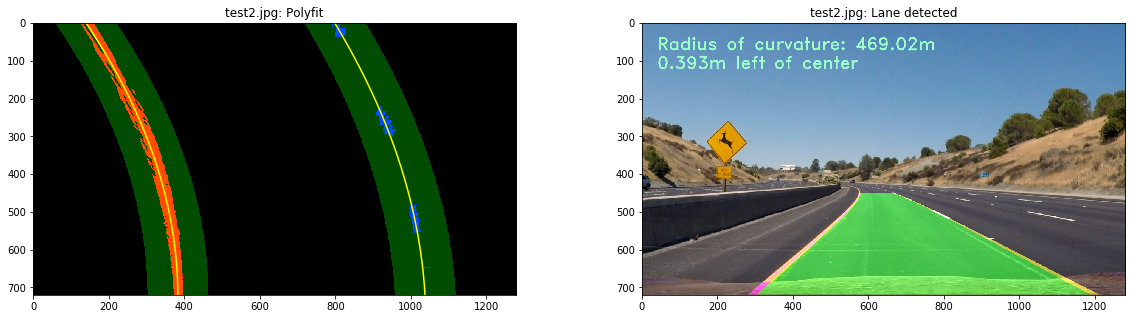

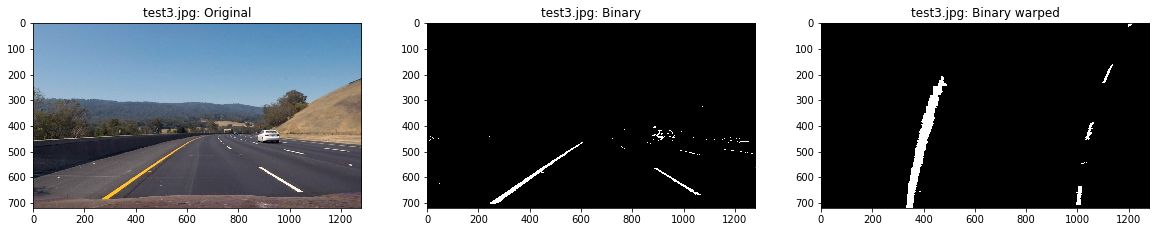

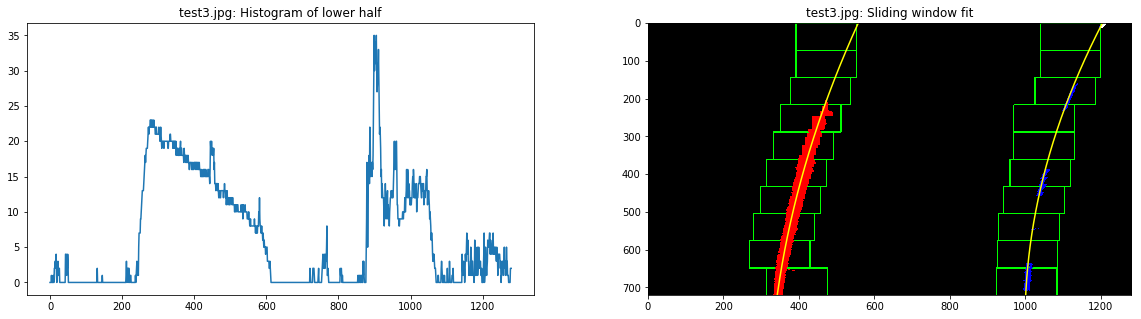

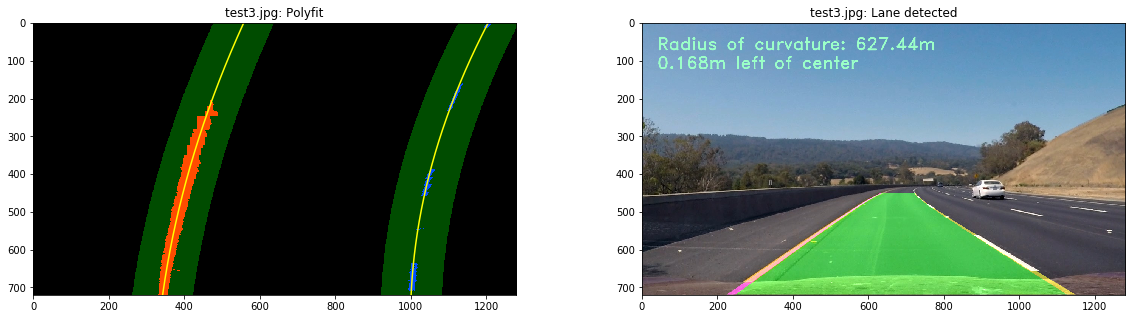

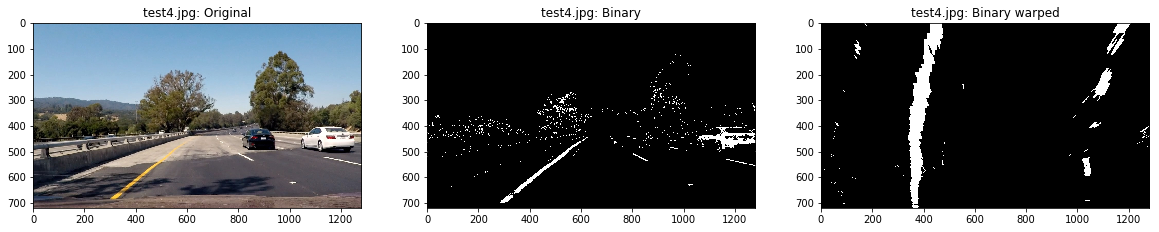

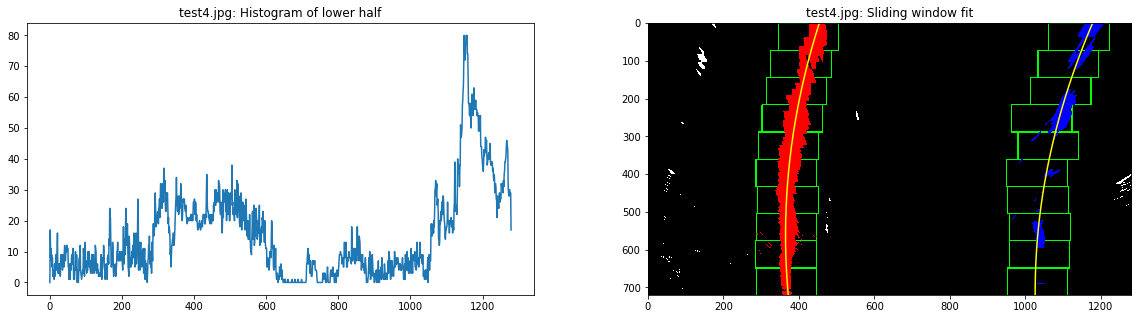

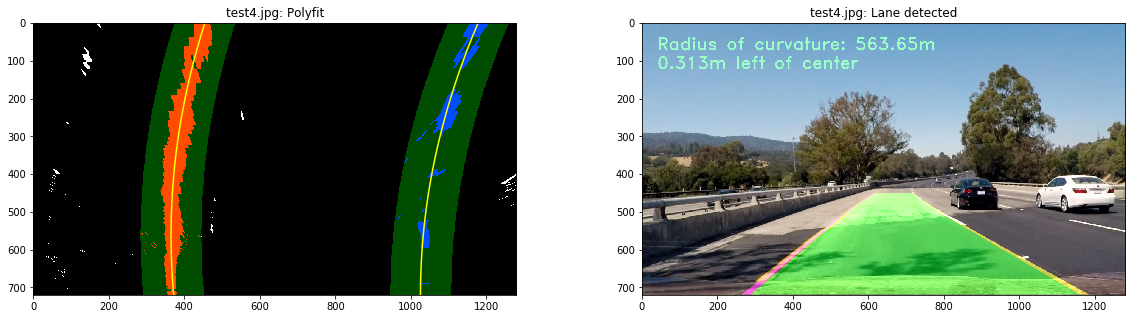

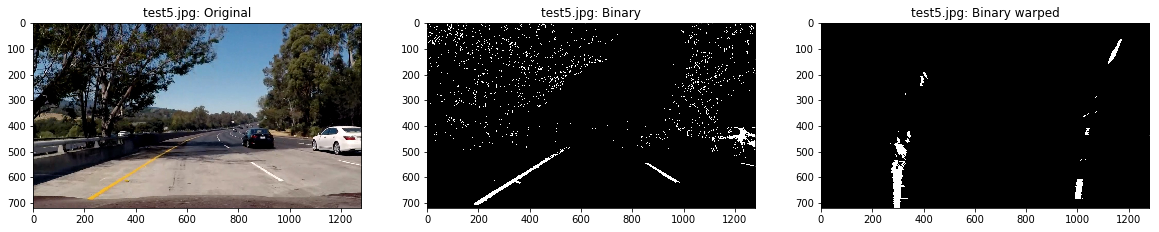

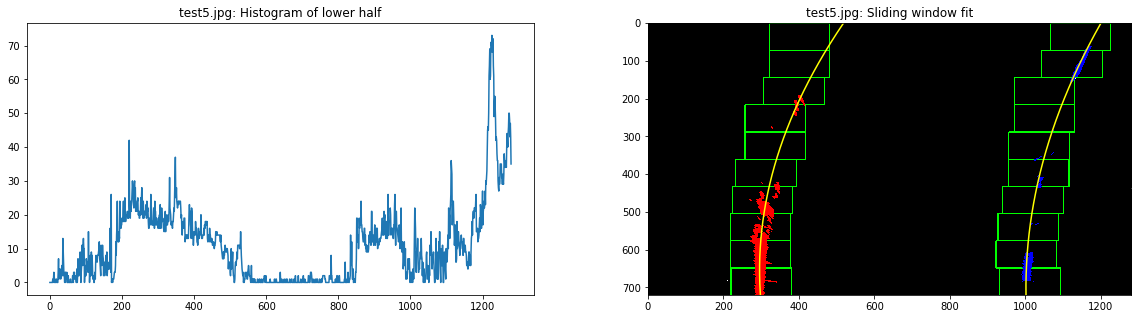

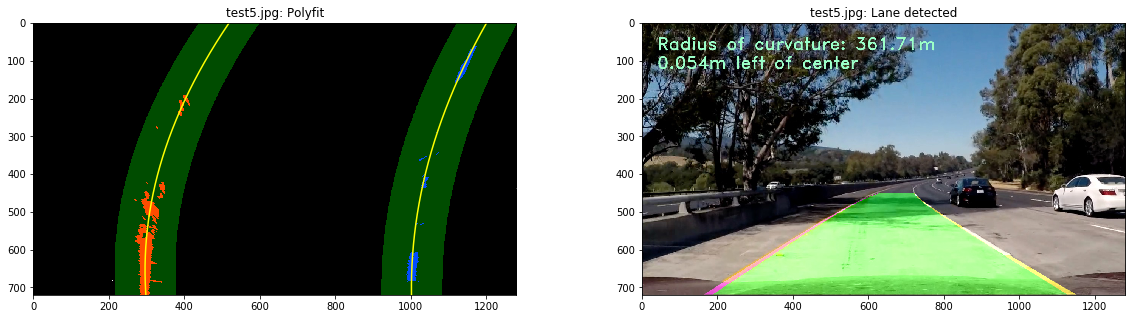

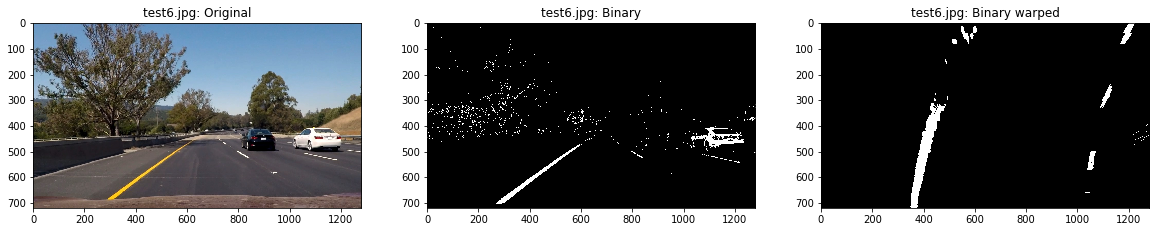

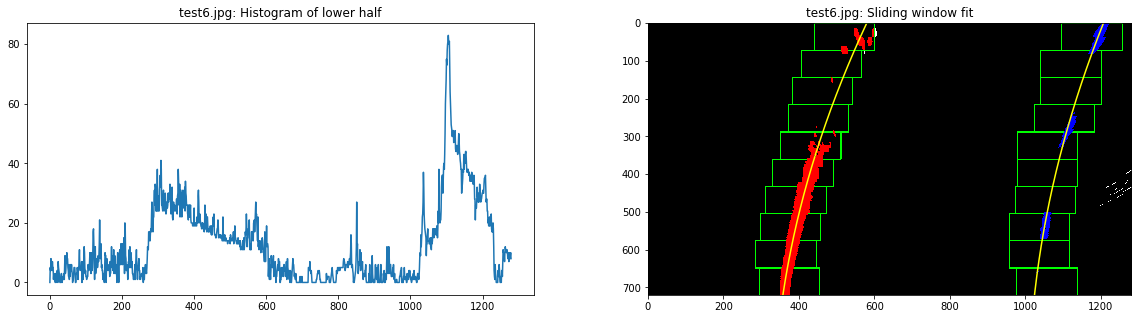

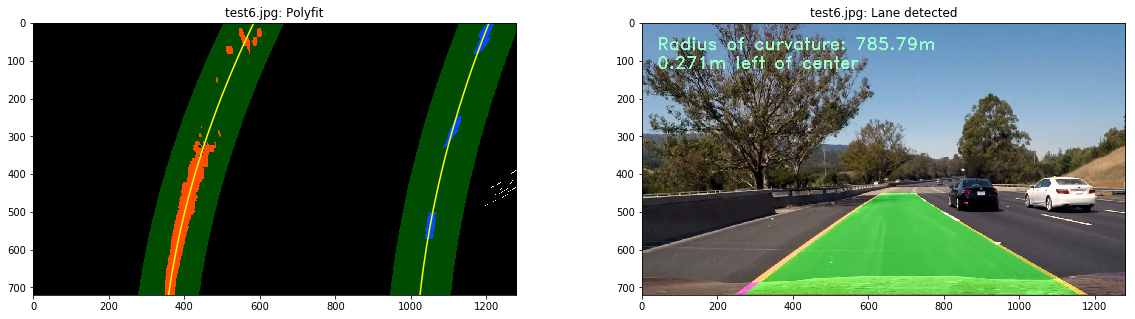

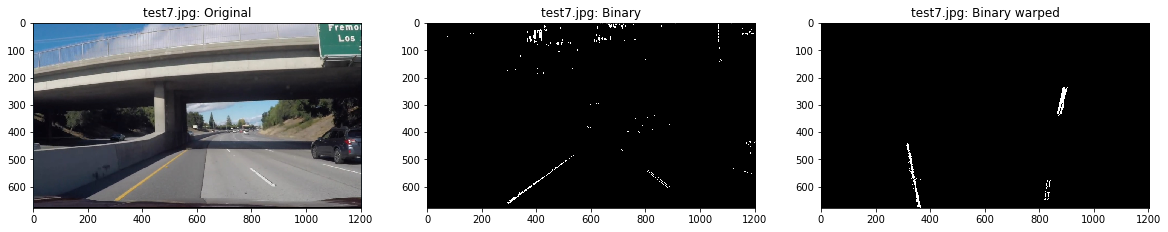

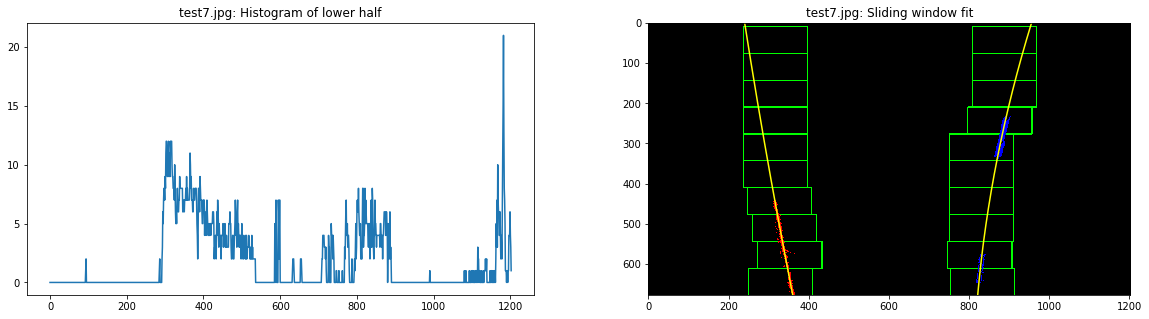

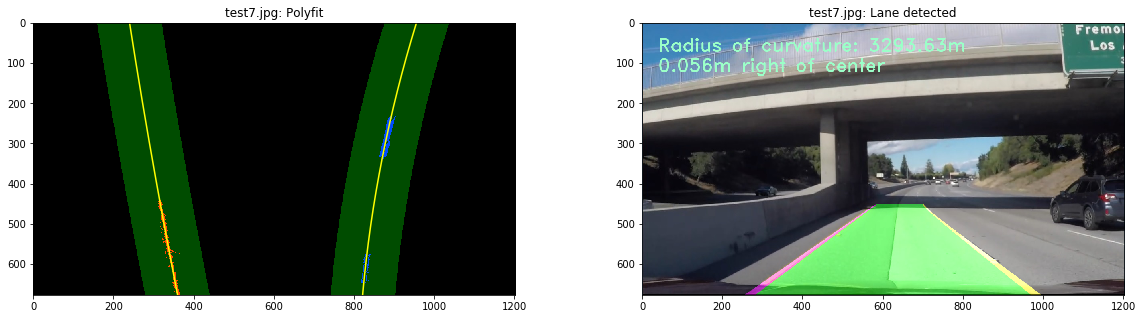

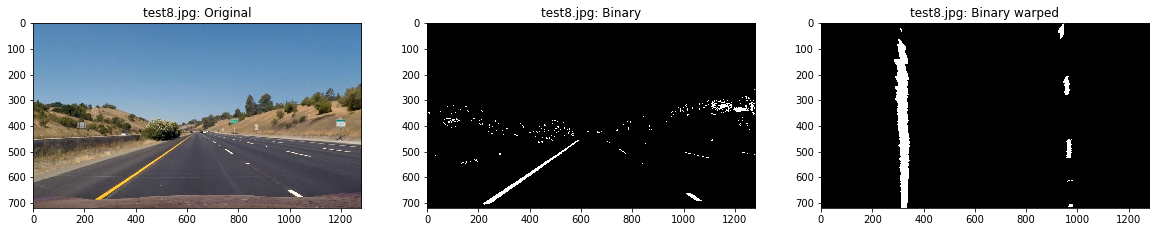

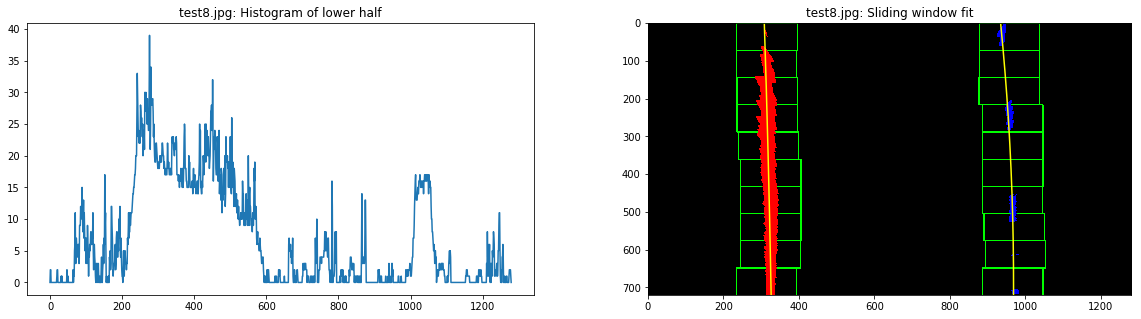

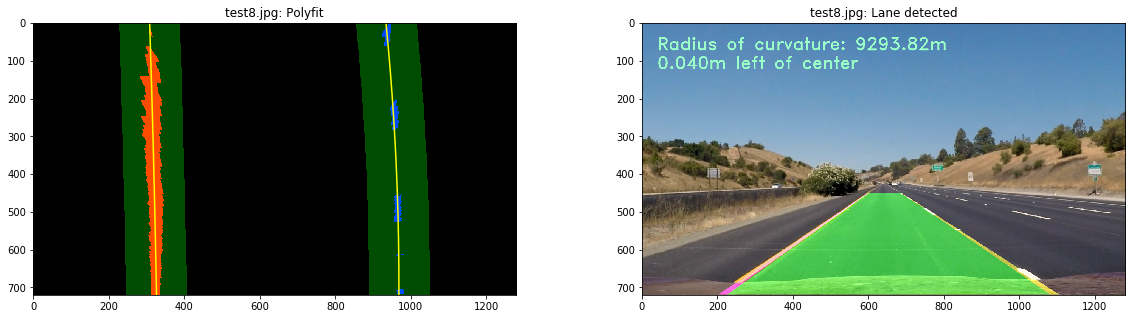

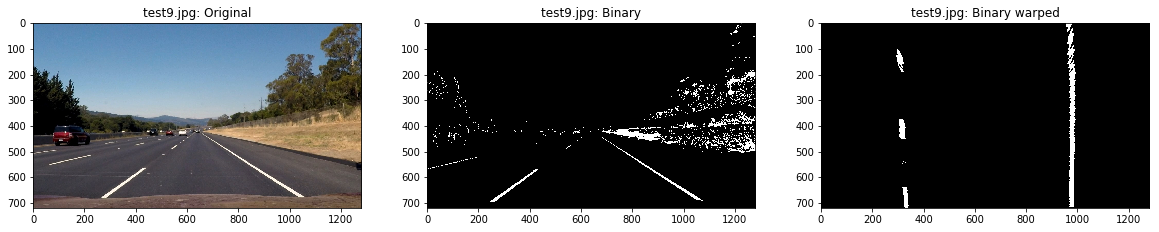

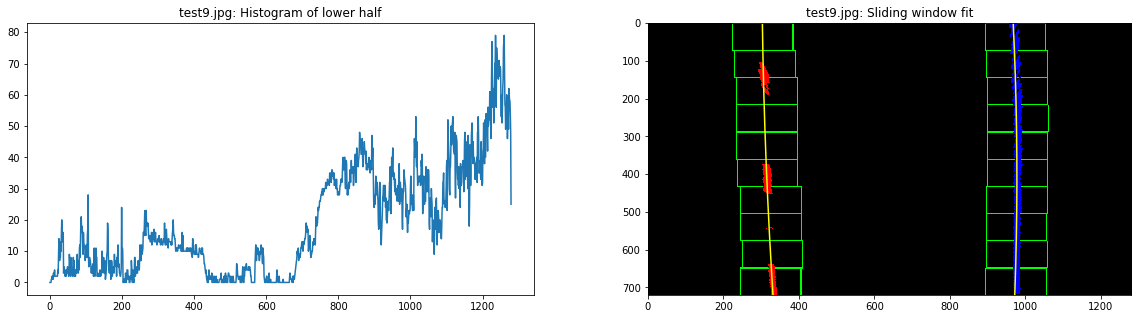

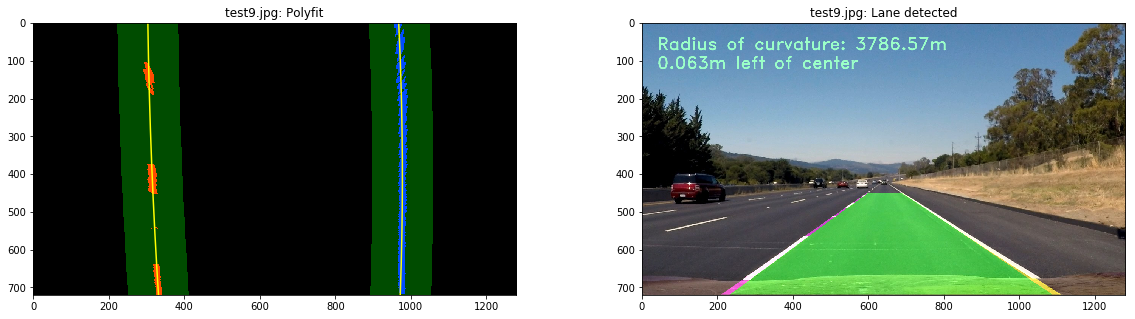

In [108]:
p = Pipeline()

for i in range(1,10):
    file = 'test'+str(i)+'.jpg'
    img = cv2.imread(config['test_images_folder'] + '/' + file)

    combined_binary = p.get_binary_image(img)
    
    top_down, M, Minv = p.perspective_transformed(img)
    
    histogram = p.histogram_of_perspective_transformed_binary_image(combined_binary)
    
    
    
    # Plotting thresholded images
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    ax1.set_title(file + ': Original')
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    ax2.set_title(file + ': Binary')
    ax2.imshow(combined_binary, cmap='gray')
    
    ax3.set_title(file + ': Binary warped')
    ax3.imshow(top_down, cmap='gray')
    
    f, (ax4, ax5) = plt.subplots(1, 2, figsize=(20,5))
    ax4.set_title(file + ': Histogram of lower half')
    ax4.plot(histogram)

    result = p.sliding_window_polyfit(top_down)
    ax5.set_title(file + ': Sliding window fit')
    p.sliding_window_polyfit_show(top_down, result, ax5)
    
    f, (ax6, ax7) = plt.subplots(1, 2, figsize=(20,5))
    result_poly = p.polyfit_using_prev_fit(top_down, result['left_fit'], result['right_fit'])
    ax6.set_title(file + ': Polyfit')
    p.polyfit_using_prev_fit_show(top_down, result_poly, ax6)
    
    leftc, rightc, cdist = p.radius_of_curvature_and_center_distance(top_down, result)
    final_t = p.draw_lane(img, top_down, result['left_fit'], result['right_fit'], Minv)    
    final = p.curvature_data(final_t, (leftc+rightc)/2.0, cdist)
    ax7.set_title(file + ': Lane detected')
    ax7.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))
    

# 6. Create output videos 

## 6.1. Project video

In [109]:
x = VideoFileClip('project_video.mp4')

In [110]:
y = x.fl_image(p.process_image)

In [111]:
y.write_videofile('project_video_output.mp4')

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing audio in project_video_outputTEMP_MPY_wvf_snd.mp3


100%|████████████████████████████████████████████████████████████████████████████| 1112/1112 [00:00<00:00, 1882.95it/s]


[MoviePy] Done.
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:28<00:00,  8.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

